In [27]:
import numpy as np
import pandas as pd

import pymysql
import dotenv
import os
import pickle
import seaborn as sns
import matplotlib

from datetime import timedelta, datetime

import matplotlib.pyplot as plt

# Normalization/Standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Conv1D, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import Sequential, save_model, load_model  # save_model, load_model은 2버전부터 models에 속함
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.saving import save_model, load_model

# 경고 무시 코드 추가
import warnings
warnings.filterwarnings('ignore')

def pltconfig_default() :
  sns.reset_defaults()
  %matplotlib inline

pltconfig_default()

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list

In [28]:
# 모델 불러오기 테스트

lstm_load_path = f"./Models/all_data/new_data/lstm_model_stne_all"

lstm_model = load_model(lstm_load_path)

In [29]:
# 해당 모델의 scaler 불러오기

with open('scaler.pkl', 'rb') as f :
    scaler = pickle.load(f)

In [30]:
# 샘플 데이터 만들기

def make_sample(df, year, month, day) :
  
  if '일사량' in df and '적설량' in df :
    df = df.drop(['일사량', '적설량'], axis=1)
  
  filter_forecast_1 = (df['년'] == year) & (df['월'] == month) & (df['일'] == day-1) & (df['시간'] > 20)
  filter_forecast_2 = (df['년'] == year) & (df['월'] == month) & (df['일'] == day)

  sample_df = pd.concat([df[filter_forecast_1], df[filter_forecast_2]], axis=0)

  result_df = sample_df.iloc[3:, -1]
  sample_df = sample_df.iloc[:,:-1]   # 금일 발전량 제외


  print(sample_df)
  print(result_df)

  with open(f'sample_data_{year}{str(month).zfill(2)}{str(day).zfill(2)}', 'wb') as f :
      pickle.dump(sample_df, f)

  with open(f'result_data_{year}{str(month).zfill(2)}{str(day).zfill(2)}', 'wb') as f :
      pickle.dump(result_df, f)

  return sample_df, result_df

# test_data = make_sample(NonNormal_data, 2022, 10, 13)

# print(test_data)

In [31]:
# 예측값 추출 함수 (정규화/표준화 적용)

def data_trans(data_set, scaler, model) :
    predict_result = []

    row_idx = data_set.shape[0]
    print(row_idx)

    df_scaled = pd.DataFrame(scaler.transform(data_set.iloc[:, 4:]))
    df_scaled = df_scaled.fillna(0.0)

    date_set = data_set.iloc[:, :4]
    date_set.reset_index(drop=True, inplace=True)

    data = pd.concat([date_set, df_scaled], axis=1)


    for i in range(row_idx-3):
        data_t = data.iloc[i:i+3:1, 4:].to_numpy()
        test_set = data_t.reshape(1, data_t.shape[0], data_t.shape[1])
        y_pred = model.predict(test_set)   
        predict_result.append(y_pred)

    return predict_result

In [32]:
# 졍규화/표준화하지 않은 데이터

NonNormal_data = pd.read_pickle("final_data")

print(NonNormal_data.tail())

          년   월   일  시간  강수량   풍속     풍향    습도  일조시간  일사량  적설량  전운량      시정  \
17513  2022  12  31  19  0.0  0.8  360.0  47.0   0.0  0.0  0.0  0.0  2879.0   
17514  2022  12  31  20  0.0  0.1    0.0  53.0   0.0  0.0  0.0  0.0  2823.0   
17515  2022  12  31  21  0.0  0.0    0.0  62.0   0.0  0.0  0.0  0.0  2567.0   
17516  2022  12  31  22  0.0  0.6  320.0  70.0   0.0  0.0  0.0  0.0  2047.0   
17517  2022  12  31  23  0.0  0.1    0.0  75.0   0.0  0.0  0.0  0.0  1592.0   

       지면온도  금일발전량  
17513  -1.1    0.0  
17514  -1.6    0.0  
17515  -2.3    0.0  
17516  -2.8    0.0  
17517  -3.3    0.0  


In [33]:
want_date = input('예측할 날짜를 입력해주세요(양식 : yyyy-mm-dd) (샘플데이터 범위(2021,2022)) : ')
select_date = want_date.split('-')

try :
    test_data = make_sample(NonNormal_data, int(select_date[0]), int(select_date[1]), int(select_date[2]))

    with open(f'sample_data_{select_date[0]}{select_date[1]}{select_date[2]}', 'rb') as f :
        sample_data = pickle.load(f)
        
    with open(f'result_data_{select_date[0]}{select_date[1]}{select_date[2]}', 'rb') as f :
        result_data = pickle.load(f)

    pred_data = data_trans(sample_data, scaler, lstm_model)

    pred_data = [x[0] for x in pred_data]
    result_data.reset_index(drop=True, inplace=True)
except :
    print('데이터 형태가 맞지 않습니다.')

       년  월  일  시간  강수량   풍속     풍향    습도  일조시간  전운량      시정  지면온도
20  2021  1  1  21  0.0  0.5   90.0  70.0   0.0  3.0  1516.0  -1.4
21  2021  1  1  22  0.0  0.2    0.0  76.0   0.0  0.0  1541.0  -2.1
22  2021  1  1  23  0.0  0.0    0.0  81.0   0.0  0.0  1108.0  -2.8
23  2021  1  2   0  0.0  0.1    0.0  83.0   0.0  0.0  1029.0  -3.4
24  2021  1  2   1  0.0  0.0    0.0  86.0   0.0  0.0   830.0  -3.8
25  2021  1  2   2  0.0  0.1    0.0  85.0   0.0  0.0  1179.0  -3.6
26  2021  1  2   3  0.0  0.0    0.0  84.0   0.0  8.0  1395.0  -2.5
27  2021  1  2   4  0.0  0.0    0.0  77.0   0.0  9.0  1669.0  -2.4
28  2021  1  2   5  0.0  0.1    0.0  79.0   0.0  9.0  1668.0  -2.6
29  2021  1  2   6  0.0  0.2    0.0  85.0   0.0  0.0  1467.0  -3.2
30  2021  1  2   7  0.0  0.0    0.0  84.0   0.0  0.0  1379.0  -3.9
31  2021  1  2   8  0.0  0.0    0.0  82.0   0.5  1.0  1328.0  -2.9
32  2021  1  2   9  0.0  0.0    0.0  76.0   0.7  4.0  1515.0  -2.0
33  2021  1  2  10  0.0  0.0    0.0  70.0   0.8  4.0  1366.0  

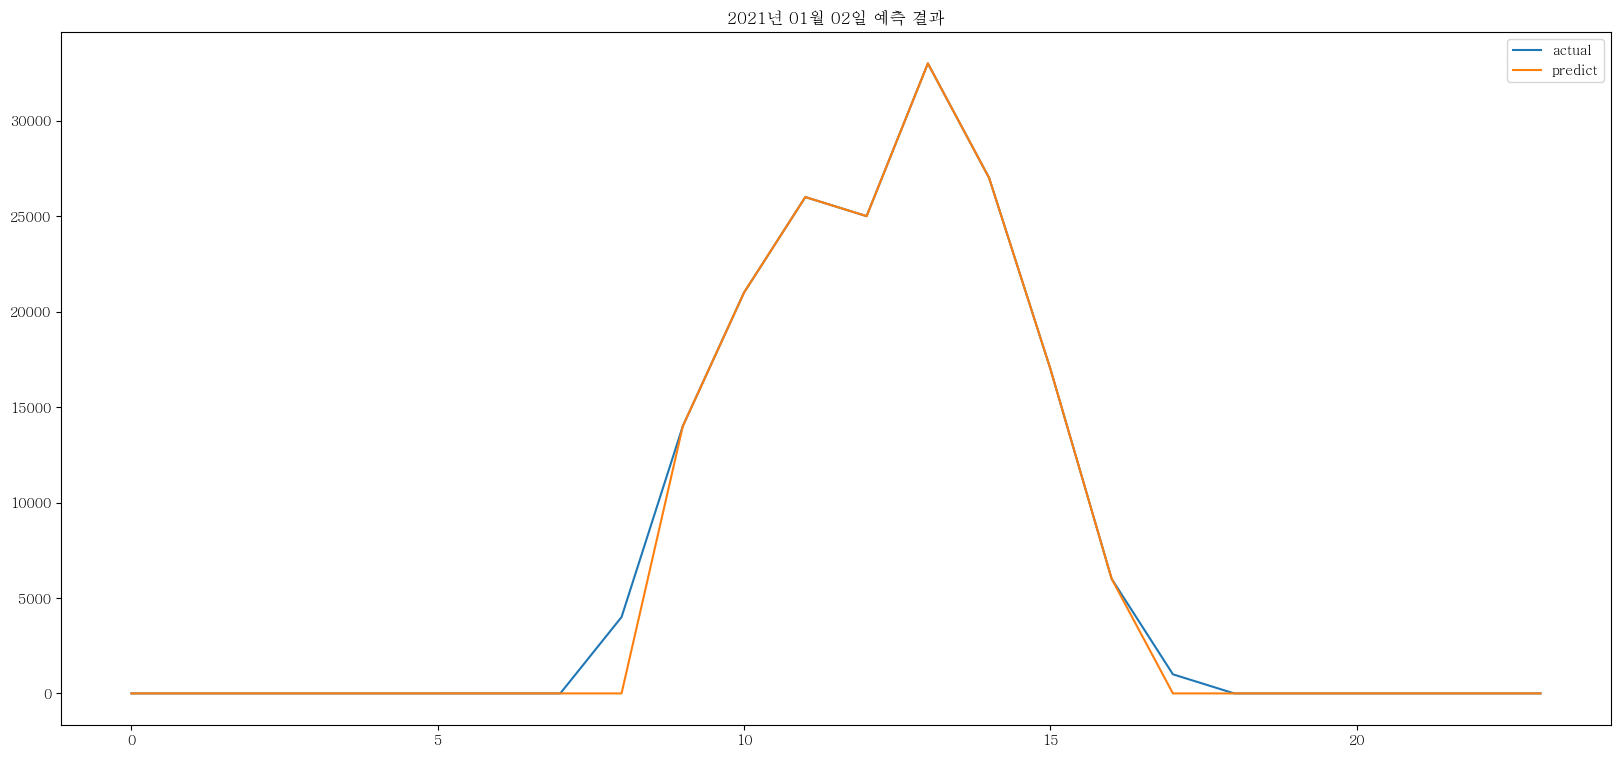

In [34]:
plt.figure(figsize=(20, 9))
plt.plot(result_data, label='actual')
plt.plot(pred_data, label='predict')
plt.legend()
plt.title(f'{select_date[0]}년 {select_date[1]}월 {select_date[2]}일 예측 결과')
plt.show()

In [ ]:
# 향후 예보 데이터를 가져와 DB에 쌓고 스케줄러를 통해 주기적으로 실시간 예측 현황 반영 프로세스 추가